# Data mining Toronto Fire Incidents Final Report

## Abstract
The objective of this project is to build predictors to estimate the financial impact of fire incidents, using open fire incident data from the city of Toronto. By analysing factors including, but not limited to, the extent of fire, source of fire, ignition material and property use, we aim to provide an accurate estimation of the amount of dollar loss per fire incident. The project seeks to uncover these circumstantial factors that affect the financial impact per every fire incident in Toronto.


This project uses open soruce data published by the City of Toronto: <https://open.toronto.ca/dataset/fire-incidents/>

The dataset includes fire incidents as defined by the Ontario Fire Marshal (OFM) up to December 31, 2022. It contains 43 columns and nearly 30k rows.

---
## Pipeline
At a high level, the pipeline achieves the following:

- `Pipeline`
  - `Data_Preprocessing`
    - `Data_cleaning`
      - Drops columns with no relevance.
      - Sanitizes descrepancies for manual input data.
      - Replaces empty strings in categorical columns with `pd.NA`.
      - Drops rows with no values at all according to feature: `Area_of_Origin`.
      - Removes false positives, according to feature: `Final_Incident_Type`
      - Converts non-null values of categorical columns to string to ensure data integrity, ease the imputation processs.
      - Removes outliers using z-score method to eliminate rows that 3 standard deviations from the mean, based on response feature, `Estimated_Dollar_Loss`.
      - Replaces values of `NAType` with `np.nan` for numerical columns.
    - `Feature_Engineering` 
      - creates a new feature `Control_Time`. (How long fire burned for.)
      - creates a new feature called `Response_Time`. (How long took for the first arriving unit to get to the incident)
    - `feature_transformers`
      - Applies simple imputer to all categorical features.
      - Applies KNN imputer to all numerical features.
      - Applies ordinal encoding to all categorical features.
      - Standard scale all numerical features.
      - Applies log transformation on response variable.
    - `Feature Selection`
      - Drops features with low Spearman correlation coefficients to response variable.
      - Drops categorical features with low Kruskal-Wallis H-test statistic to response variable.
      - Drops categorical features with low Chi-Squared test statistic to response variable.
      - Removes 4 worst features using `SelectKBest` method with an ANOVA F-test.
  - `model(regressors)` 
    - Linear models
      - Multiple Linear Regression (OLS - Ordinary Least Squares) 
      - Lasso (Least Absolute Shrinkage and Selection Operator)
      - Elastic-Net
      - Huber Regressor
    - Ensemble methods
      - Random Forest Regressor
      - XGBoost Regressor
    - Non-Linear Models
      - Neural networks (MLP - Multi-layer Perceptron)

The hyperparameters of models were tuned using `GridSearchCV`.

### Custom Modules Developed
- data_clean.py

  Classes:
  
  - `DataCleaner`:
  
    **Functions**:
    - `cleanse_dataframe(df)`: Returns a cleansed dataframe.
    

- data_reduction.py

  Classes:
  
  - `FeatureAnalysis`:
  
    **Functions**:
    
    - `keepStrongestFeaturesInDataFrame(responseVariable, df, p_value, correlation)`: Returns a dataframe with features that have a strong correlation and statistical significance to `responseVariable`.
---

## Data Analysis and Visualization
See `src/ExpDataAnalysis.ipynb` and `src/proposal/hypothesis_testing.ipynb`

## Data Preprocessing Pipeline

In [102]:
# Third Party libraries
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

from sklearn.linear_model import LinearRegression

In [103]:
# Load DF
df = pd.read_csv('../../data/raw/Fire_Incidents_Data.csv', low_memory=False)

In [104]:
# Feature Engineering before removing columns

df['Fire_Under_Control_Time'] = pd.to_datetime(df['Fire_Under_Control_Time'])
df['TFS_Alarm_Time'] = pd.to_datetime(df['TFS_Alarm_Time'])
df['TFS_Arrival_Time'] = pd.to_datetime(df['TFS_Arrival_Time'])

df['Control_Time'] = (df['Fire_Under_Control_Time'] - df['TFS_Alarm_Time']).dt.total_seconds()
df['Response_Time'] = (df['TFS_Arrival_Time'] - df['TFS_Alarm_Time']).dt.total_seconds()

### Cleanse dataframe.
See modules/data_clean.py, or `Data_Cleaning` section of Pipeline Objectives for more details.

In [105]:
# Import custom Data_cleaning module
from modules.data_clean import DataCleaner

# Cleanse Dataframe
df = DataCleaner.cleanse_dataframe(df)

### Defining all features.
- Numerical Columns
- Categorial Columns
    - Ordinal Columns
    - Onehot Columns

In [106]:
NUMERICAL_COLS = [
    "Civilian_Casualties",
    "Count_of_Persons_Rescued",
    "Estimated_Dollar_Loss",
    "Estimated_Number_Of_Persons_Displaced",
    "Number_of_responding_apparatus",
    "Number_of_responding_personnel",
    "TFS_Firefighter_Casualties",
    "Control_Time", 
    "Response_Time"
]

CATEGORICAL_COLS = ['Area_of_Origin', 'Building_Status', 'Business_Impact', 'Extent_Of_Fire', 'Final_Incident_Type', 
                'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence', 
                'Ignition_Source', 'Initial_CAD_Event_Type', 'Material_First_Ignited', 'Method_Of_Fire_Control', 
                'Possible_Cause', 'Property_Use', 'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 
                'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation', 
                'Smoke_Spread', 'Sprinkler_System_Operation', 'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival', 'Incident_Ward']

# ['Business_Impact', 'Extent_Of_Fire', 'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival']
ORDINAL_COLS = CATEGORICAL_COLS[2:4] + CATEGORICAL_COLS[20:22]

# Everything else.
ONEHOT_COLS = list(set(CATEGORICAL_COLS) - set(ORDINAL_COLS))

### Imputation

#### Categorical Imputation

A SimpleImputer is applied to all `CATEGORICAL_COLS`, as it can work with string data types.

In [107]:
# Specify pd.NA as the missing value indicator for SimpleImputer
import numpy as np

imputer = SimpleImputer(strategy='most_frequent', missing_values=pd.NA)

# Apply the imputer to the categorical columns
df[CATEGORICAL_COLS] = imputer.fit_transform(df[CATEGORICAL_COLS])

#### Numerical imputation.

A KNN imputer is applied to all `NUMERICAL_COLS` missing data.

In [108]:
import numpy as np

# Replace pd.NA with np.nan
# KNNImputer does not directly support pd.NA
df = df.replace(pd.NA, np.nan)

imputer = KNNImputer()

# Apply the imputer to the categorical columns
df[NUMERICAL_COLS] = imputer.fit_transform(df[NUMERICAL_COLS])

### Categorical Encoding

This will encode all `CATEGORICAL_COLS`.

In [109]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import numpy as np

# Specify ordinal encoder
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)

# Apply the encoder to specified columns
df[CATEGORICAL_COLS] = ordinal_encoder.fit_transform(df[CATEGORICAL_COLS])

### Standard scaler on numerical Data

Apply standard scaling to all `NUMERICAL_COLS`.
Standardizes features by removing the mean and scaling to unit variance to create a normal distribution.
Many models may assume normally distributed data.

In [110]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the DataFrame
df[NUMERICAL_COLS] = scaler.fit_transform(df[NUMERICAL_COLS])

[]


### Log transform response variable.
Log transform the `responseVariable`, to improve heteroskedasticity (make the residual variance appear more constant) and normality (reduce the skewness of the data). 

In [11]:
# Log transform the Estimated_Dollar_Loss column
df['Estimated_Dollar_Loss'] = np.log(df['Estimated_Dollar_Loss'] + 1)  # Adding 1 to avoid log(0) issue

### Feature Selection (Part 1)
Select features based on the following:
- Spearman correlation coefficients with p-values for each categorical feature.
- Kruskal-Wallis H-test statistic for each categorical feature
- Calculate Chi-Squared test statistic for each categorical feature

Using these values, a measure of `p-value` and `correlation` is developed for each column against the response variable.

Columns are kept so long as its `(['P-value'] < 0.1) & (['Correlation'] > 0.003)`.

This will drop the following features: {'Final_Incident_Type', 'Smoke_Alarm_at_Fire_Origin'}. Increasing the correlation threshold any more will drop more features and will result in a worse r-sq.

In [12]:
# Import Data_reduction module
from modules.data_reduction import FeatureAnalysis

# helper function that will drop low correlated variables in the dataset
df_reduced = FeatureAnalysis.keepStrongestFeaturesInDataFrame('Estimated_Dollar_Loss', df, 0.1, 0.003)

### Train test split

In [13]:
from sklearn.model_selection import train_test_split
df = df_reduced
# List all columns in the DataFrame
all_columns = df.columns.tolist()

# Use every other column in the df except for the response variable
features = [col for col in all_columns if col != 'Estimated_Dollar_Loss']

# Separate features from response variable
X, y = df[features], df['Estimated_Dollar_Loss']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

### Feature Selection (Part 2)

Perform feature selection using the SelectKBest method from with an ANOVA F-test (f_classif). It then removes the worst four features from both the training and testing sets.

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif

# Perform feature selection using SelectKBest with ANOVA F-test
k_best_features = SelectKBest(score_func=f_classif, k=X_train.shape[1]) # Select all features initially
X_train_selected = k_best_features.fit_transform(X_train, y_train)

# Get the scores and indices of the features
feature_scores = k_best_features.scores_

# Get a list of indexes based on the value of the index's element. Sorted.
# The list of indexes is generated by the range function. (len(feature_scores))
feature_indices = sorted(range(len(feature_scores)), key=lambda i: feature_scores[i], reverse=True)

# Identify the worst four features to remove
features_to_remove = [feature_indices[-1], feature_indices[-2], feature_indices[-3], feature_indices[-4]]

# remove the worst four features from both training and testing sets
X_train = X_train.drop(X_train.columns[features_to_remove], axis=1)
X_test = X_test.drop(X_test.columns[features_to_remove], axis=1)


---
## Modelling Implementation and Evaluation

### Helper Functions

In [15]:
# Function: Print Results of a Model (R2, MEAN ABSOLUTE ERROR, MEAN SQUARED ERROR, COEF and INTERCEPT).
def print_results(r2, mae, mse, coefficients, intercept):
    print(f"R-squared score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"Coefficients: {coefficients}")
    print(f"Intercept: {intercept}")

# Function: Return Results (R2, MEAN ABSOLUTE ERROR, MEAN SQUARED ERROR, COEF and INTERCEPT)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def get_results(model, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    coefficients = model.coef_
    intercept = model.intercept_
    return (r2, mae, mse, coefficients, intercept)

# Function: Plot Scatter plot for regression model. (y_pred = lr.predict(X_test), R2 Score)
import matplotlib.pyplot as plt
import seaborn as sns
def plotRegression(y_pred, r2, modelName=None):
    # Scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.8)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')  # Identity line
    plt.title(f'Actual vs. Predicted ({modelName})')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # Annotate plot with R-squared value
    plt.text(y_test.min(), y_test.max(), f'$R^2 = {r2:.2f}$', fontsize=12, verticalalignment='top')

    plt.show()

### Linear Regression

---------MLR----------
R-squared score: 0.5005
Mean Absolute Error: 0.1885541610880164
Mean Squared Error: 0.09082654811349446
Coefficients: [-6.03237515e-04  9.07617670e-03  2.20463029e-02  4.03249487e-03
  2.95734300e-02  3.52263677e-02  5.40422886e-03  2.63843115e-03
  1.43456053e-02 -5.32225358e-05  1.63343605e-03 -1.87189687e-02
 -1.40112864e-01  3.27864841e-01  1.83400740e-03  1.98049938e-04
  1.03167919e-02  2.07188823e-03 -2.73848219e-03  3.44884662e-03
  1.31544149e-03 -1.82642147e-02  3.15689721e-02  2.08844500e-02
  2.22179295e-02]
Intercept: -0.5170101162484535


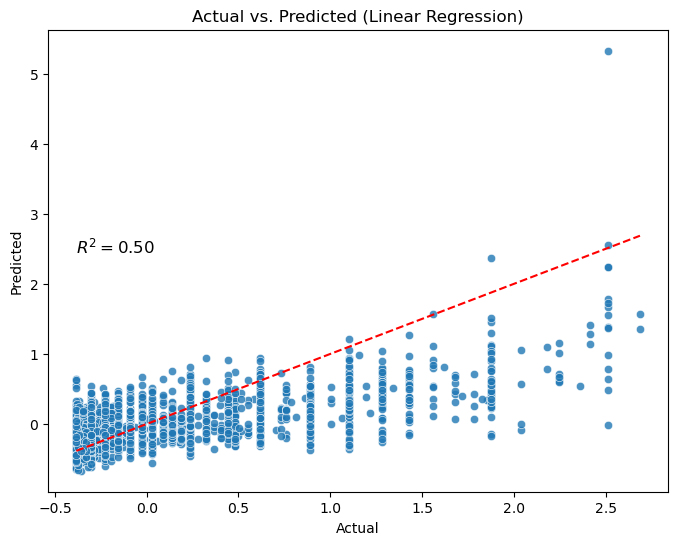

----------------------


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr = LinearRegression() 
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
residuals_lr = y_test - y_pred_lr

(r2_lr, mae_lr, mse_lr, coefficients_lr, intercept_lr) = get_results(lr, y_test, y_pred_lr)

# Results - Another option would be to use statsmodels to display a summary
print("---------MLR----------")
print_results(r2_lr, mae_lr, mse_lr, coefficients_lr, intercept_lr)
plotRegression(y_pred_lr, r2_lr, 'Linear Regression')
print("----------------------")

### Lasso Regression

---------LASSO----------
R-squared score: 0.0050
Mean Absolute Error: 0.27546187522614746
Mean Squared Error: 0.18093335069258049
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.00015448  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
Intercept: -0.125698781208276
------------------------


---------LASSO CV BEST----------
R-squared score: 0.4902
Mean Absolute Error: 0.1870998903408478
Mean Squared Error: 0.09271636404302167
Coefficients: [-4.43928675e-04  8.10169938e-03  9.28989271e-03  0.00000000e+00
  2.24547034e-02  3.58710302e-02  3.47166606e-03  0.00000000e+00
  4.34747804e-03 -2.58207933e-05  1.67300008e-03 -1.14196740e-02
  1.55946271e-01  3.16098038e-02  2.21873756e-03  1.54448249e-04
  8.77290506e-03  0.00000000e+00  0.00000000e+00  3.04083041e-03
 -0.00000000e+00 -0.00000000e+00  3.03908328e-02  1.38122884e-02
  1.34876372e-02]
Intercept: -0.5237731159897542


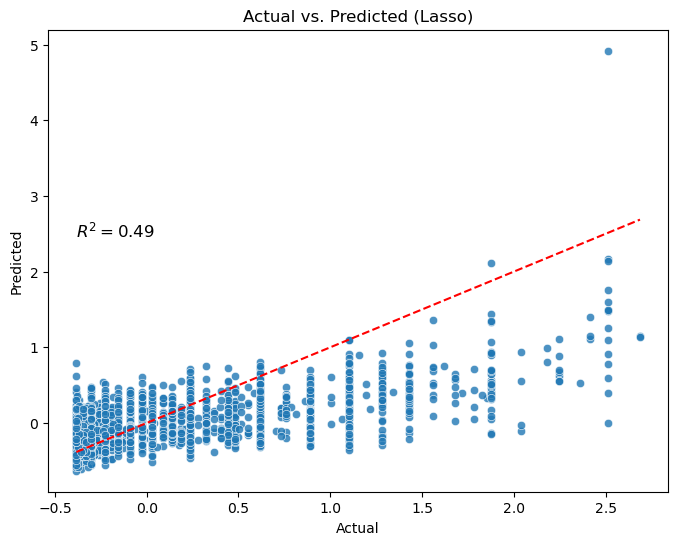

---------------------------


In [17]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Need to scale before using Lasso. Done in preprocessing

# Lasso Model 1 = basic

lasso = Lasso(tol=0.05)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
(r2_lasso, mae_lasso, mse_lasso, coefficients_lasso, intercept_lasso) = get_results(lasso, y_test, y_pred_lasso)

print("---------LASSO----------")
print_results(r2_lasso, mae_lasso, mse_lasso, coefficients_lasso, intercept_lasso)
print("------------------------")

# Lasso Model 2 = Testing different parameters (CROSS-VALIDATOR: CV)

param_grid = {
	'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]	
}

lasso_cv = GridSearchCV(lasso, param_grid, cv=3, n_jobs=-1)
lasso_cv.fit(X_train, y_train)

# Get the Lasso with the best estimators
lasso_best = lasso_cv.best_estimator_
y_pred_lasso_best = lasso_best.predict(X_test)
(r2_lasso_best, mae_lasso_best, mse_lasso_best, coefficients_lasso_best, intercept_lasso_best) = get_results(lasso_best, y_test, y_pred_lasso_best)

print("---------LASSO CV BEST----------")
print_results(r2_lasso_best, mae_lasso_best, mse_lasso_best, coefficients_lasso_best, intercept_lasso_best)
plotRegression(y_pred_lasso_best, r2_lasso_best, 'Lasso')
print("---------------------------")

### ElasticNet

---------ELASTIC NET BASIC----------
R-squared score: 0.0171
Mean Absolute Error: 0.27223163393691796
Mean Squared Error: 0.1787360446760427
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.0002938   0.00080467 -0.
  0.          0.          0.         -0.00037746  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
Intercept: -0.15707875966865387
---------------------------
---------ELASTIC BEST CV----------
R-squared score: 0.4860
Mean Absolute Error: 0.18796568279373058
Mean Squared Error: 0.093463413322066
Coefficients: [-0.00048634  0.00809941  0.01017923  0.          0.02228831  0.03673514
  0.00300404  0.          0.00388058 -0.          0.00164354 -0.01265215
  0.07739217  0.09686308  0.00227374  0.00013964  0.00880723  0.
  0.          0.0034091  -0.         -0.          0.0298837   0.01514389
  0.01838877]
Intercept: -0.51930000625453


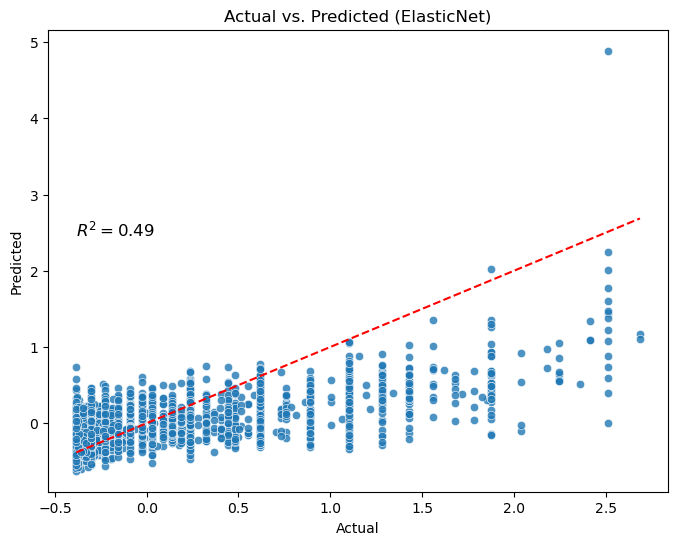

---------------------------


In [18]:
from sklearn.linear_model import ElasticNet

# X_train and X_test should be scaled

# ElasticNet Model 1 = basic

elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)

y_pred_elastic_net = elastic_net.predict(X_test)

(r2_elastic_net, mae_elastic_net, mse_elastic_net, coefficients_elastic_net, intercept_elastic_net) = get_results(elastic_net, y_test, y_pred_elastic_net)

print("---------ELASTIC NET BASIC----------")
print_results(r2_elastic_net, mae_elastic_net, mse_elastic_net, coefficients_elastic_net, intercept_elastic_net)
print("---------------------------")

# ElasticNet Model 2 = Testing different parameters (CROSS-VALIDATOR: CV)

param_grid = {
	'alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],	
	'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 	
}

elastic_cv = GridSearchCV(elastic_net, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
elastic_cv.fit(X_train, y_train)

# Get the Elastic with the best estimators
elastic_best = elastic_cv.best_estimator_
y_pred_elastic_best = elastic_best.predict(X_test)
(r2_elastic_best, mae_elastic_best, mse_elastic_best, coefficients_elastic_best, intercept_elastic_best) = get_results(elastic_best, y_test, y_pred_elastic_best)

print("---------ELASTIC BEST CV----------")
print_results(r2_elastic_best, mae_elastic_best, mse_elastic_best, coefficients_elastic_best, intercept_elastic_best)
plotRegression(y_pred_elastic_best, r2_elastic_best, 'ElasticNet')
print("---------------------------")




### XGBRegressor

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
Best cross-validation score: 0.63
R-squared score: 0.6583
Mean Absolute Error: 0.13951366645057664
Mean Squared Error: 0.06213834505077028


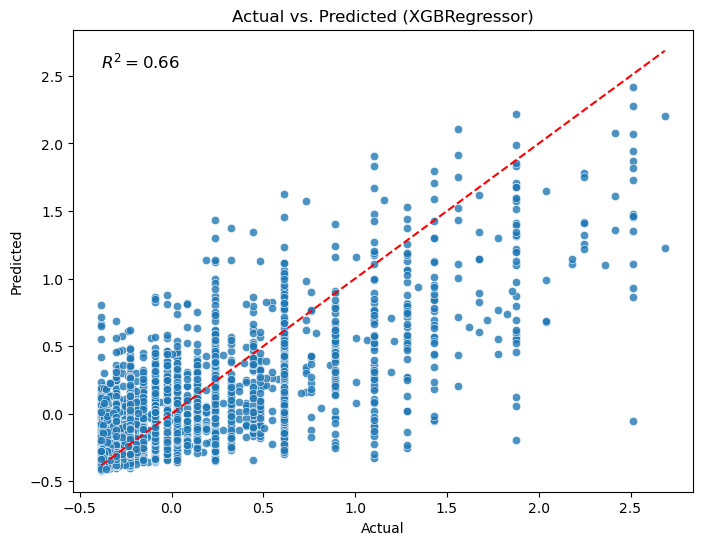

In [19]:
import multiprocessing
import xgboost as xgb

# Initialize XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
    n_jobs=-1, tree_method="hist"
)

# XGB Hyperparamters hav been tuned using this CV param grid.
# Not including parameters 'subsample' or 'colsample_bytree' due to resource usage.
param_grid = {"max_depth": [2, 4, 6], 
              "n_estimators": [50, 100, 200],
              'gamma': [0, 0.1, 0.2, 0.3, 0.4],
              'learning_rate': [0.05, 0.1, 0.2, 0.3]}

# Cross validate model. Find the best hyperparamters using the grid above
xgb_cv = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    verbose=1,
    n_jobs=2
)

# fit model
xgb_cv.fit(X_train, y_train)

# Best model parameters from GridSearchCV
print("Best parameters:", xgb_cv.best_params_)
print("Best cross-validation score: {:.2f}".format(xgb_cv.best_score_))

# Predict on the test data
xgb_y_pred = xgb_cv.predict(X_test)


xgb_r2 = r2_score(y_test, xgb_y_pred)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_mse = mean_squared_error(y_test, xgb_y_pred)

print(f"R-squared score: {xgb_r2:.4f}")
print(f"Mean Absolute Error: {xgb_mae}")
print(f"Mean Squared Error: {xgb_mse}")
plotRegression(xgb_y_pred, xgb_r2, 'XGBRegressor')

### Huber Regression

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'alpha': 0.0001, 'epsilon': 2.0, 'max_iter': 1000, 'warm_start': True}
Best cross-validation score: 0.42
---------HUBER REGRESSOR----------
R-squared score: 0.4845
Mean Absolute Error: 0.17671432508880264
Mean Squared Error: 0.09375232865828498
Coefficients: [-6.84700514e-04  5.80654816e-03  1.37583191e-02  1.12053267e-03
  2.55391710e-02  2.44282755e-02  6.75608475e-03 -2.10255117e-03
  1.01851520e-02 -1.14869050e-04  1.68147357e-03 -6.29269396e-03
  1.64660983e-01  4.13398307e-02  1.46134194e-03  2.76678240e-04
  7.09619014e-03  6.66932699e-04 -3.11120719e-03  3.53575159e-03
  2.90341637e-03 -1.20478113e-02  2.09197877e-02  2.96616935e-02
  5.65468492e-02]
Intercept: -0.49742955012550333


c:\Python\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


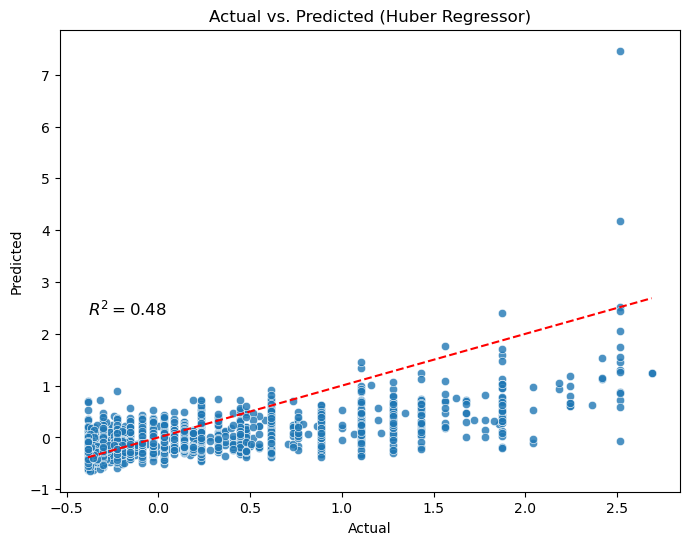

----------------------------------


In [40]:
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# HuberRegressor Setup
huber = HuberRegressor()

# GridSearchCV
param_grid = {
    'epsilon': [1.35, 1.5, 2.0],
    'max_iter': [1000, 1500, 2000],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'warm_start': [True, False]
}
#Best parameters: {'alpha': 0.001, 'epsilon': 2.0, 'max_iter': 1000, 'warm_start': True}
grid_search = GridSearchCV(huber, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model parameters from GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Using best parameters to fit Huber regressor
huber_best = grid_search.best_estimator_
huber_best.fit(X_train, y_train)
y_pred_huber = huber_best.predict(X_test)

# Store best scores
r2_huber = huber_best.score(X_test, y_test)
mae_huber = mean_absolute_error(y_test, y_pred_huber)
mse_huber = mean_squared_error(y_test, y_pred_huber)

# Get results using the helper function
print("---------HUBER REGRESSOR----------")
print_results(r2_huber, mae_huber, mse_huber, huber_best.coef_, huber_best.intercept_)
plotRegression(y_pred_huber, r2_huber, 'Huber Regressor')
print("----------------------------------")


### Random Forest Regressor

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# RandomForestRegressor with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]
}
#Best parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
rf = RandomForestRegressor(random_state=12) 
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Output the best parameters and the best score from the grid search
print("Best parameters:", grid_search_rf.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_rf.best_score_))

# Fit the best model from the grid search
rf_best = grid_search_rf.best_estimator_
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)

# Store best scores
r2_rf = rf_best.score(X_test, y_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Get results using helper function
print("---------RANDOM FOREST REGRESSOR----------")
print_results(r2_rf, mae_rf, mse_rf, rf_best.feature_importances_, rf_best.intercept_ if hasattr(rf_best, 'intercept_') else 0)
plotRegression(y_pred_rf, r2_rf, 'Random Forest Regressor')
print("----------------------------------")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

### MLP REGRESSOR

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'activation': 'tanh', 'alpha': 0.01, 'batch_size': 32, 'early_stopping': True, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.005, 'n_iter_no_change': 10, 'validation_fraction': 0.1}
Best cross-validation score: 0.42
---------MLP REGRESSOR----------
R-squared score: 0.4751
Mean Absolute Error: 0.20134687709558402
Mean Squared Error: 0.0954568126536821
Coefficients: []
Intercept: 0


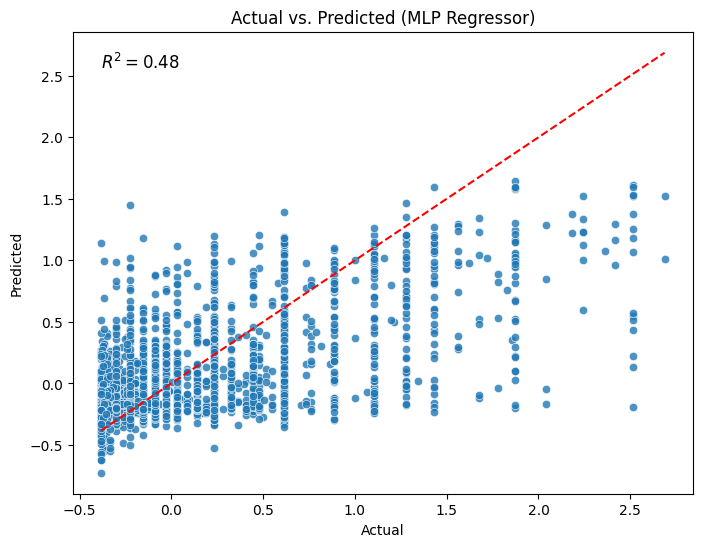

----------------------------------


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

mlp = MLPRegressor(random_state=12)

# MLP Regressor with GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50), (50, 50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.005, 0.01, 0.02],
    'learning_rate_init': [0.0005, 0.001, 0.005],
    'batch_size': [32, 64, 128],
    'early_stopping': [True],  # Early stopping enabled
    'validation_fraction': [0.1, 0.2],  # Different sizes of validation fraction
    'n_iter_no_change': [10]  # Number of iterations with no improvement
}
#{'activation': 'tanh', 'alpha': 0.01, 'batch_size': 32, 'early_stopping': True, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.0005, 'n_iter_no_change': 10, 'validation_fraction': 0.2}

grid_search = GridSearchCV(mlp, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model parameters from GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Using best parameters to fit MLPRegressor
mlp_best = grid_search.best_estimator_
mlp_best.fit(X_train, y_train)
y_pred_mlp = mlp_best.predict(X_test)

# Store best scores
r2_mlp = mlp_best.score(X_test, y_test)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)

# Get results using helper function
print("---------MLP REGRESSOR----------")
print_results(r2_mlp, mae_mlp, mse_mlp, [], 0)
plotRegression(y_pred_mlp, r2_mlp, 'MLP Regressor')
print("----------------------------------")


### Model Evaluation Comparison 

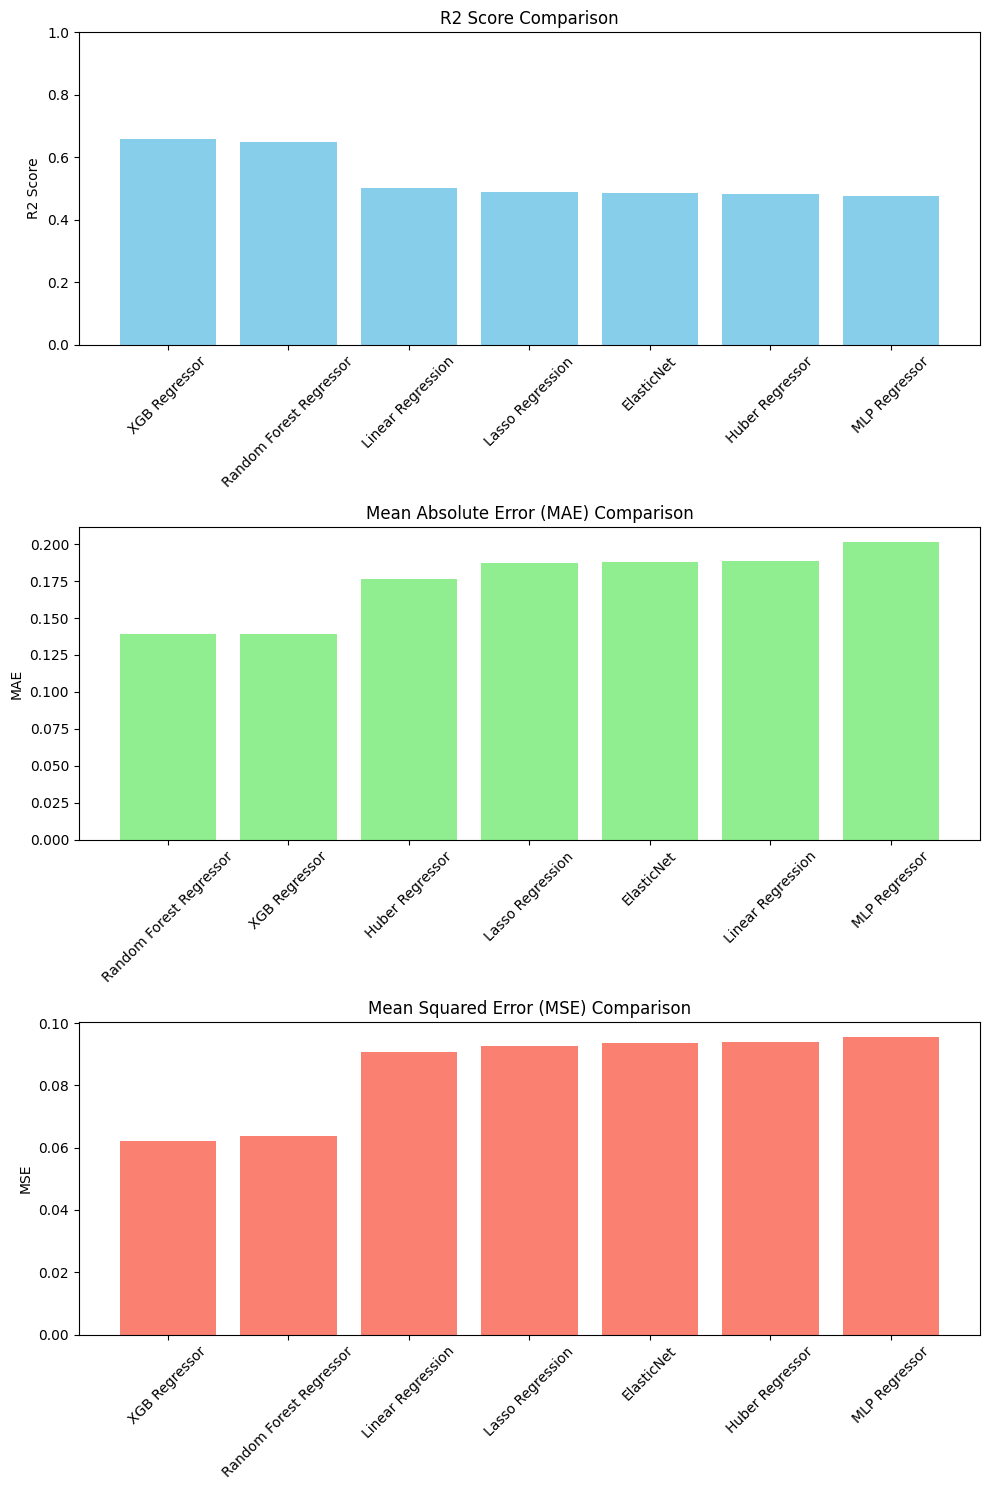

Sorted Results by R2 Score:


,Model,R2 Score,MAE,MSE
3,XGB Regressor,0.658300,0.139514,0.062138
1,Random Forest Regressor,0.649787,0.139081,0.063686
6,Linear Regression,0.500543,0.188554,0.090827
5,Lasso Regression,0.490150,0.187100,0.092716
4,ElasticNet,0.486042,0.187966,0.093463
2,Huber Regressor,0.483590,0.176682,0.093909
0,MLP Regressor,0.475081,0.201347,0.095457


In [ ]:
# Define model names and their evaluation metrics
models = [
    ("MLP Regressor", r2_mlp, mae_mlp, mse_mlp),
    ("Random Forest Regressor", r2_rf, mae_rf, mse_rf),
    ("Huber Regressor", r2_huber, mae_huber, mse_huber),
    ("XGB Regressor", xgb_r2, xgb_mae, xgb_mse),
    ("ElasticNet", r2_elastic_best, mae_elastic_best, mse_elastic_best),
    ("Lasso Regression", r2_lasso_best, mae_lasso_best, mse_lasso_best),
    ("Linear Regression", r2_lr, mae_lr, mse_lr)
]

# Create a DataFrame to store model names and metrics
results_df = pd.DataFrame(models, columns=["Model", "R2 Score", "MAE", "MSE"])

# Sort DataFrame by R2 Score (descending order)
results_df.sort_values(by="R2 Score", ascending=False, inplace=True)

# Plotting the comparison of R2 scores, MAE, and MSE
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Bar plot for R2 Score
axes[0].bar(results_df["Model"], results_df["R2 Score"], color='skyblue')
axes[0].set_title("R2 Score Comparison")
axes[0].set_ylabel("R2 Score")
axes[0].set_ylim(0, 1) 
axes[0].tick_params(axis='x', rotation=45)  

# Sort DataFrame by MAE (ascending order)
results_df.sort_values(by="MAE", ascending=True, inplace=True)

# Bar plot for MAE
axes[1].bar(results_df["Model"], results_df["MAE"], color='lightgreen')
axes[1].set_title("Mean Absolute Error (MAE) Comparison")
axes[1].set_ylabel("MAE")
axes[1].tick_params(axis='x', rotation=45)  

# Sort DataFrame by MSE (ascending order)
results_df.sort_values(by="MSE", ascending=True, inplace=True)

# Bar plot for MSE
axes[2].bar(results_df["Model"], results_df["MSE"], color='salmon')
axes[2].set_title("Mean Squared Error (MSE) Comparison")
axes[2].set_ylabel("MSE")
axes[2].tick_params(axis='x', rotation=45)  

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

# Display the sorted DataFrame
print("Sorted Results by R2 Score:")
results_df

<Axes: >

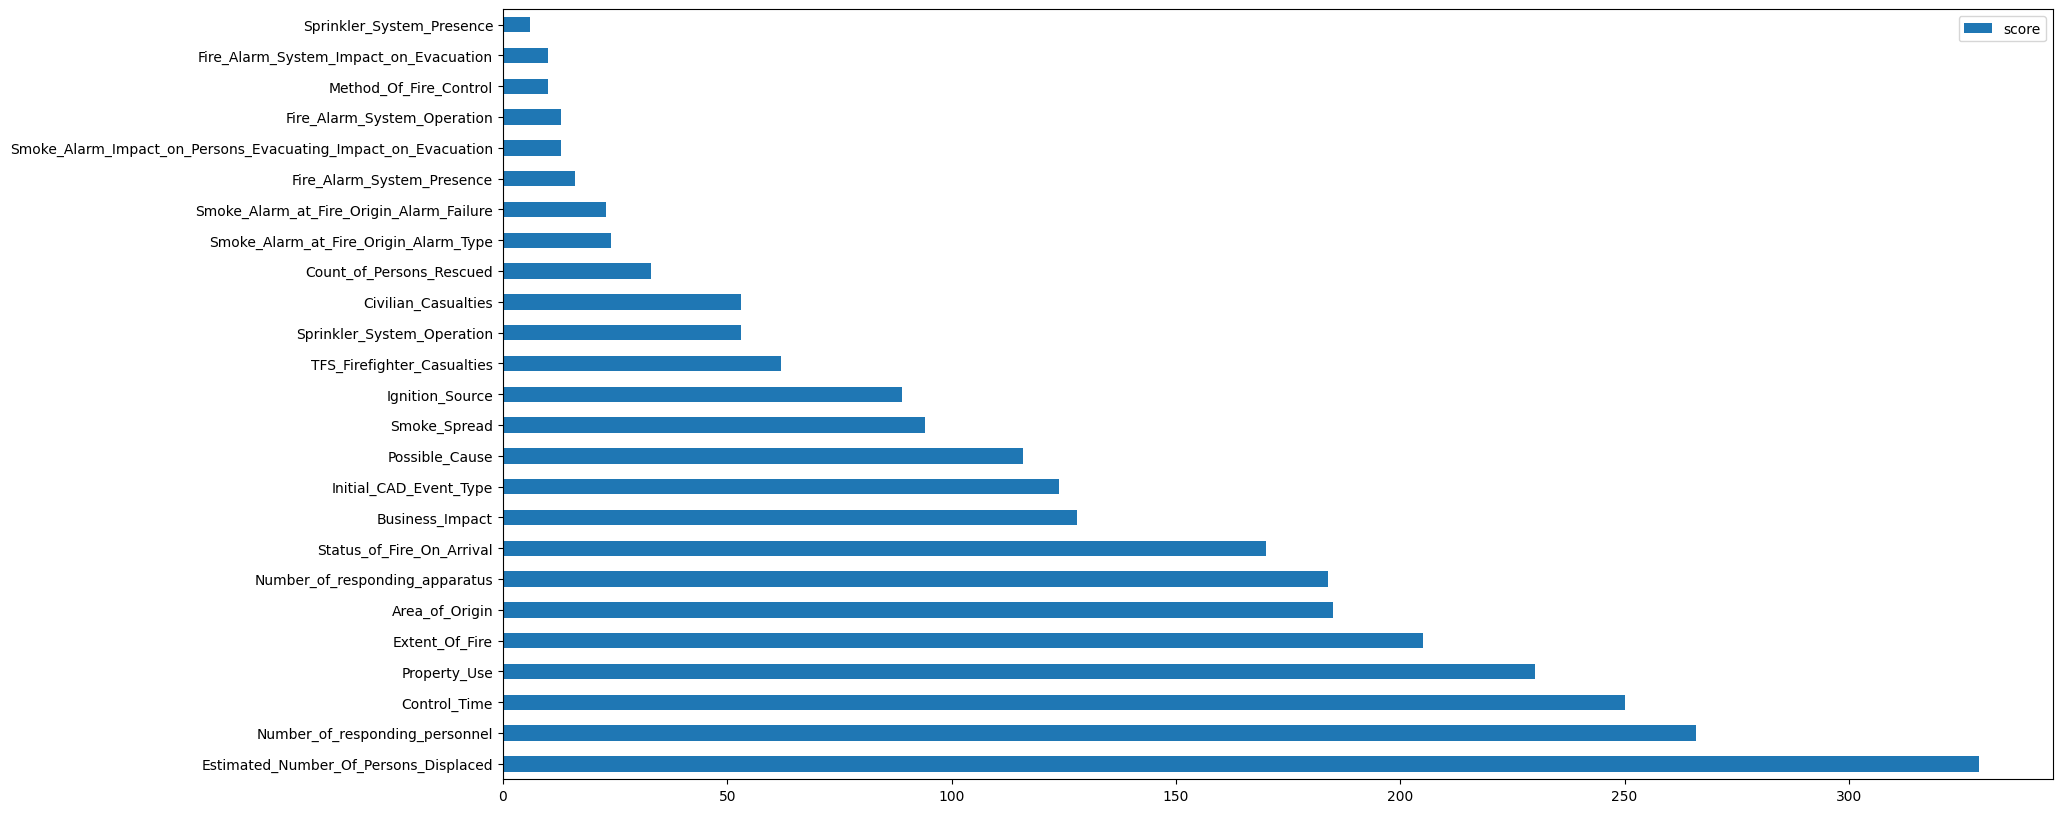

In [ ]:
best_xgb_model = xgb_cv.best_estimator_  # Access the best XGBoost model from GridSearchCV

# Retrieve feature importance scores from the best XGBoost model
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Extract keys (feature names) and values (importance scores) from the feature importance dictionary
keys = list(feature_importance.keys())
values = list(feature_importance.values())

# Create a DataFrame to visualize the top 40 features by importance
data = pd.DataFrame(data=values, index=keys, columns=["score"])
top_features = data.nlargest(40, columns="score")

# Plot the top 40 features by importance in a horizontal bar chart
top_features.plot(kind='barh', figsize=(20, 10))

### Conclusion and Insights

#### Key Findings

#### Implications

### Annex: Pipeline

In [142]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from modules.data_clean import DataCleaner
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import numpy as np
import pandas as pd

df_pipeline = pd.read_csv('../../data/raw/Fire_Incidents_Data.csv', low_memory=False)
df_pipeline['Fire_Under_Control_Time'] = pd.to_datetime(df_pipeline['Fire_Under_Control_Time'])
df_pipeline['TFS_Alarm_Time'] = pd.to_datetime(df_pipeline['TFS_Alarm_Time'])
df_pipeline['TFS_Arrival_Time'] = pd.to_datetime(df_pipeline['TFS_Arrival_Time'])
df_pipeline['Control_Time'] = (df_pipeline['Fire_Under_Control_Time'] - df_pipeline['TFS_Alarm_Time']).dt.total_seconds()
df_pipeline['Response_Time'] = (df_pipeline['TFS_Arrival_Time'] - df_pipeline['TFS_Alarm_Time']).dt.total_seconds()

# Cleanse Dataframe
df_pipeline = DataCleaner.cleanse_dataframe(df_pipeline)
df_pipeline = df_pipeline.replace(pd.NA, np.nan)
df_pipeline['Estimated_Dollar_Loss'] = np.log(df_pipeline['Estimated_Dollar_Loss'] + 1)  # Adding 1 to avoid log(0) issue

# List all columns in the DataFrame
all_columns = df_pipeline.columns.tolist()

# Use every other column in the df except for the response variable
features = [col for col in all_columns if col != 'Estimated_Dollar_Loss']

# Separate features from response variable
X, y = df_pipeline[features], df_pipeline['Estimated_Dollar_Loss']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

try:
    NUMERICAL_COLS.remove('Estimated_Dollar_Loss')
except:
    pass

simple_imputer = SimpleImputer(strategy='most_frequent', missing_values=pd.NA)
knn_imputer = KNNImputer()
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
scaler = StandardScaler()

# NUMERICAL = knn, standard scaler
num_linear_processor = make_pipeline(
     knn_imputer,
     scaler
)

# CATEGORICAL = simple, ordinal
cat_linear_processor = make_pipeline(   
    simple_imputer,
    ordinal_encoder
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, NUMERICAL_COLS),
    (cat_linear_processor, CATEGORICAL_COLS)
)

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', linear_preprocessor),
                           ('classifier', LinearRegression())])


# fit the pipeline to train a regression model on the training set
model = pipeline.fit(X_train, y_train)

# Impute missing values in X_test using the same imputer (preprocessor)
X_test_imputed = model.named_steps['preprocessor'].transform(X_test)
# Need to convert back to DF to be used in prediction
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=X_test.columns)
print(X_test_imputed_df.columns[X_test_imputed_df.isna().any()].tolist()) # problem
y_pred_mlp = model.predict(X_test_imputed_df)


# estimators = [
#     ('linear_regression', lr),
#     ('lasso', lasso_best),
#     ('elasticnet', elastic_best),
#     ('xgbregressor', xgb_cv.best_estimator_),
#     ('rfregressor', RandomForestRegressor(random_state=12, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100, n_jobs=-1)), 
#     ('mlpregressor', MLPRegressor(random_state=12, activation='tanh', alpha= 0.01, batch_size=32, early_stopping=True, hidden_layer_sizes= (100, 50), learning_rate_init=0.0005, n_iter_no_change=10, validation_fraction=0.2))
# ]



['Number_of_responding_personnel', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure']


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values